# Speech Emotion Recognition


#### Task Description：
Fine-tune Hubert model on the RAVDESS dataset for Speech Emotion Recognition.


#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

## 1. General Preparation

Import some common libraries.

In [1]:
import time
from tqdm import tqdm

Use GPU Facilities.

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


## 2. Data Processing

### 2.1 Load RAVDESS dataset

Download dataset file from website https://zenodo.org/record/1188976

In [5]:
# ![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

'[' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
import os

file_path = "Audio_Speech_Actors_01-24.zip"
if not os.path.exists(file_path):
    import urllib.request
    url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
    urllib.request.urlretrieve(url, file_path)

Unzip dataset file.

In [9]:
# ![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"a

'[' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
import zipfile

file_path = "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"
if not os.path.exists(file_path):
    with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", "r") as zip_ref:
        zip_ref.extractall("./Audio_Speech_Actors_01-24/")

In [13]:
import pandas as pd
import os

RAV = "./Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for folder in dir_list:
    author = folder.split("_")[-1]  # Trích xuất số tác giả từ tên thư mục
    fname = os.listdir(os.path.join(RAV, folder))
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))  # Trích xuất cảm xúc từ phần tử thứ 3
        temp = int(author)
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)  # Sử dụng giới tính được trích xuất từ số tác giả
        path.append(os.path.join(RAV, folder, f))

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: emotion, dtype: int64

In [4]:
# import pandas as pd

# RAV = "./Audio_Speech_Actors_01-24/"
# dir_list = os.listdir(RAV)
# dir_list.sort()

# emotion = []
# gender = []
# path = []
# for i in dir_list:
#     fname = os.listdir(RAV + i)
#     for f in fname:
#         part = f.split('.')[0].split('-')
#         emotion.append(int(part[2]))
#         temp = int(part[6])
#         if temp%2 == 0:
#             temp = "female"
#         else:
#             temp = "male"
#         gender.append(temp)
#         path.append(RAV + i + '/' + f)

        
# RAV_df = pd.DataFrame(emotion)
# RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
# RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
# RAV_df.columns = ['gender','emotion','labels']
# RAV_df['source'] = 'RAVDESS'  
# RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
# RAV_df.emotion.value_counts()

In [14]:
RAV_df

,gender,emotion,labels,source,path
0,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-01-...
1,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-01-...
2,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-01-...
3,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-01-...
4,male,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-02-...
...,...,...,...,...,...
1435,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24\03-01-08-...
1436,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24\03-01-08-...
1437,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24\03-01-08-...
1438,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24\03-01-08-...


In this demonstration, we only choose 4 emotions, neutral, happy, sad and angry.

In [15]:
RAV_df = RAV_df[(RAV_df["emotion"]=="neutral") | (RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]
# RAV_df = RAV_df[RAV_df["emotion"].isin(["happy", "sad", "angry", "surprised"])]

Split into training data and test data.

In [16]:
# RAV_df = RAV_df.sample(frac=0.1)
train_df = RAV_df.sample(frac=0.8)
test_df = RAV_df.drop(train_df.index)

Let's have a look at the training data.

In [17]:
train_df

,gender,emotion,labels,source,path
1383,female,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24\03-01-01-...
842,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_15\03-01-01-...
1038,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18\03-01-03-...
300,female,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06\03-01-01-...
872,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_15\03-01-05-...
...,...,...,...,...,...
749,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_13\03-01-05-...
34,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-05-...
387,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_07\03-01-04-...
1235,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_21\03-01-05-...


In [18]:
train_df["emotion"].value_counts()

angry      164
sad        151
happy      146
neutral     77
Name: emotion, dtype: int64

In [19]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                female
emotion                                              neutral
labels                                                     1
source                                               RAVDESS
path       ./Audio_Speech_Actors_01-24/Actor_24\03-01-01-...
Name: 1383, dtype: object


### 2.2 Tokenization

In [20]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/538 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [21]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

# class EmotionDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         pattern = {1:0, 2:0, 3:1, 4:3, 5:2, 6:0, 7:0, 8:0}
#         self.labels = [pattern.get(x, -1) for x in labels]

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)
    
# train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
# test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

## 3. Loading the Model and Optimizer 

In [22]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

## 4. Training

Prepare some utility functions.

In [23]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [24]:
from transformers import HubertForSequenceClassification

# Load pre-trained model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")

# Kiểm tra số lớp trong mô hình
num_labels = model.config.num_labels
print("Number of labels in the model:", num_labels)

# Kiểm tra số lượng nhãn trong dữ liệu
num_labels_data = len(set(train_df["labels"]))  # Thay train_df bằng DataFrame chứa dữ liệu nhãn của bạn
print("Number of labels in the data:", num_labels_data)

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

Number of labels in the model: 4
Number of labels in the data: 4


In [ ]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 5

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/5


100%|██████████| 269/269 [54:04<00:00, 12.06s/it, Loss=0.834, Accuracy=0.472]   


Epoch 2/5


100%|██████████| 269/269 [31:40<00:00,  7.06s/it, Loss=2.942, Accuracy=0.446]


Epoch 3/5


 35%|███▌      | 95/269 [20:43<46:28, 16.03s/it, Loss=0.336, Accuracy=0.474]  

Visualise the training loss and accuracy.

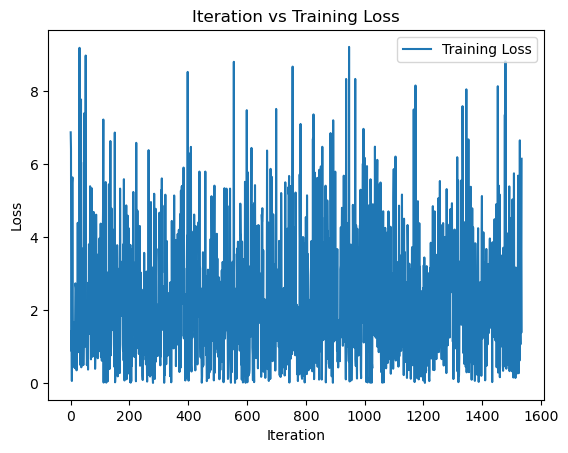

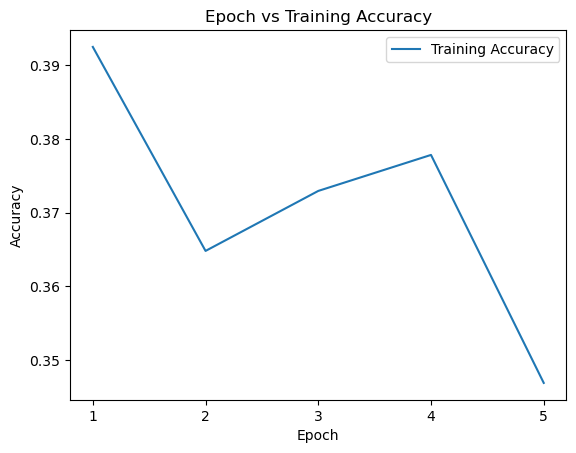

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [17]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 134/134 [02:18<00:00,  1.03s/it, loss=0.022, accuracy=0.813]


The final accuracy on the test dataset: 81.3433%


Check the result.

In [18]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]

,index,gender,emotion,labels,source,path,Model Prediction
1,12,male,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01\03-01-03-...,neu
5,75,female,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_02\03-01-03-...,neu
17,192,female,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_04\03-01-03-...,neu
31,315,female,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06\03-01-03-...,neu
33,323,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06\03-01-04-...,neu
34,327,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06\03-01-04-...,hap
36,383,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_07\03-01-04-...,neu
43,434,female,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_08\03-01-03-...,neu
51,568,female,ang,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_10\03-01-05-...,neu
56,613,male,hap,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_11\03-01-03-...,neu


Display the Confusion Matrix of the result.

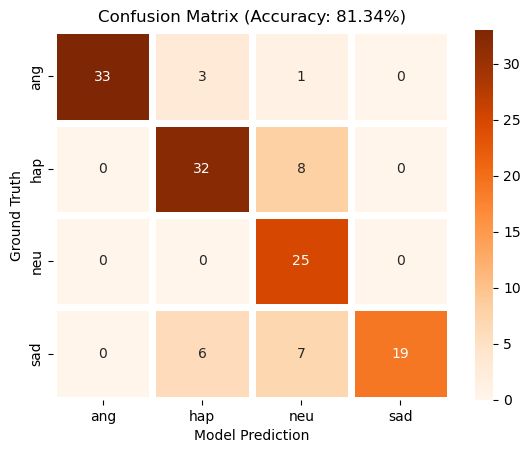

In [19]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [20]:
# Lưu mô hình sau khi huấn luyện
# model.save_pretrained("path/to/save/model")
torch.save(model.state_dict(), "path/to/save/model.pth")
# # Lưu trình tối ưu hóa nếu cần
torch.save(optim.state_dict(), "path/to/save/optimizer_state_dict")